# Import Libary

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

# Load Dataset

In [ ]:
# Load data
# If dataset already loaded, do not run this code below
from google.colab import files
uploaded = files.upload()

Saving BankChurners.csv to BankChurners.csv


In [ ]:
# load the dataset as a pandas DataFrame
data = pd.read_csv("BankChurners.csv")
# remove unnecessary columns
data.drop(labels=['CLIENTNUM', data.columns[-1], data.columns[-2]], axis=1, inplace=True)
# drop rows having NA value
#data.dropna(inplace=True)
# split into input (X) and output (y) variables
X = data.drop('Attrition_Flag', axis=1)
y = data['Attrition_Flag']

# Descriptive Dataset

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10125 non-null  float64
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10125 non-null  object 
 5   Marital_Status            10126 non-null  object 
 6   Income_Category           10125 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10125 non-null  float64
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10119 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [ ]:
# Select categories features
df_cate = data.select_dtypes(include='object')
df_num = data.select_dtypes(exclude='object')


# Preprocessing 

##Label Encoding

In [ ]:
# Source: https://github.com/Elite-Build-Team/bank-churn-prediction/blob/main/src/preprocessing.py
# Attrition and gender are binary features, thus we use label encoder to encode them.
enc = LabelEncoder()
y_enc = enc.fit_transform(y)
X["Gender"] = enc.fit_transform(X["Gender"])

# Covert minority class to 1 (positive class) label due to metrits such as
# f1-score, precision, recall in metrics package extracted from prediction of positive class
# and we care much about how the models performing with minority class

# Check target label
count_targetlb = Counter(y_enc)
print(count_targetlb)
# label 0 for majority, 1 for minority class
lb_0 = count_targetlb[0]
lb_1 = count_targetlb[1]
if lb_0 < lb_1:
    y_enc = np.where(y_enc == 0, 1, 0)
# Check result counter again
count_targetlb = Counter(y_enc)
print(count_targetlb)

# One-Hot Encoding is used for the remaining categorical features.
# [Geography]
onehot_cols = ['Education_Level', 'Income_Category', 'Card_Category', 'Marital_Status']
onehot_cols_new = pd.get_dummies(X[onehot_cols])

# Concatenate df with new columns.
X_enc = pd.concat([X, onehot_cols_new], axis=1)
X_enc.drop(onehot_cols, axis=1, inplace=True)
# Print
X_enc.head(5)

Counter({1: 8500, 0: 1627})
Counter({0: 8500, 1: 1627})


,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
0,45.0,1,3,39.0,5,1,3,12691.0,777,11914.0,...,0,0,1,0,0,0,0,1,0,0
1,49.0,0,5,44.0,6,1,2,8256.0,864,7392.0,...,1,0,1,0,0,0,0,0,1,0
2,51.0,1,3,36.0,4,1,0,3418.0,0,3418.0,...,0,0,1,0,0,0,0,1,0,0
3,40.0,0,4,34.0,3,4,1,3313.0,2517,796.0,...,1,0,1,0,0,0,0,0,0,1
4,40.0,1,3,21.0,5,1,0,4716.0,0,4716.0,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
X_enc.isna().sum().sum()

35

##Outlier

In [ ]:
# Hàm xử lý outlier
def iqr_outliers(df):
  q1 = df.quantile(0.25)
  q3 = df.quantile(0.75)
  iqr = q3-q1
  Lower_tail = q1 - 1.5 * iqr
  Upper_tail = q3 + 1.5 * iqr
  flag = 0
  for i in df:
    flag+=1 # Lấy index của các outlier
    if i > Upper_tail or i < Lower_tail:
      df[flag-1] = np.nan # Chuyển các outlier thành missing value

# Xử lý outlier thành missing trên toàn bộ tập data
for i in X_enc:
  if i  in df_num.columns: # Các biến không phải là Categori
    iqr_outliers(X_enc[i])
print(X_enc.info())  

# Xử lý missing value
from sklearn.linear_model import LinearRegression
import sklearn
sklearn.__version__

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,verbose=2,max_iter=1,tol=1e-10, imputation_order="roman")
X_miss=imp.fit_transform(X_enc)
X_enc=pd.DataFrame(X_miss,columns=X_enc.columns)
print(X_enc.info())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer_Age                    10123 non-null  float64
 1   Gender                          10127 non-null  int64  
 2   Dependent_count                 10127 non-null  int64  
 3   Months_on_book                  9739 non-null   float64
 4   Total_Relationship_Count        10127 non-null  int64  
 5   Months_Inactive_12_mon          9796 non-null   float64
 6   Contacts_Count_12_mon           9498 non-null   float64
 7   Credit_Limit                    9137 non-null   float64
 8   Total_Revolving_Bal             10127 non-null  int64  
 9   Avg_Open_To_Buy                 9159 non-null   float64
 10  Total_Amt_Chng_Q4_Q1            9727 non-null   float64
 11  Total_Trans_Amt                 9227 non-null   float64
 12  Total_Trans_Ct                  

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


##Splitting Training-Testing

In [ ]:
# Splitting 0.7 for training and 0.3 for testing

X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.3, random_state=0)

##Scaling Features

In [ ]:
# Scaliong for CV
sc = StandardScaler()
X = sc.fit_transform(X_enc)
y = y_enc

In [ ]:
# Scaling
sc = StandardScaler()  # (x - mean)/std
x1 = sc.fit_transform(X_train, y_train)
x2 = sc.transform(X_test)
X_train = pd.DataFrame(x1, columns=X_enc.columns)
X_test = pd.DataFrame(x2, columns=X_enc.columns)
# print
X_train.head(5)

,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
0,0.071555,1.058419,-0.268854,0.545638,1.414525,-1.486454,0.555004,2.068411,0.075773,2.051454,...,-0.734755,-0.352149,0.266796,-0.107517,-0.047565,-0.236018,3.546624,-0.931779,-0.800937,-0.276084
1,0.951319,1.058419,-1.040993,1.648729,0.127801,-0.019205,1.662909,-0.298444,0.081877,-0.311026,...,-0.734755,-0.352149,0.266796,-0.107517,-0.047565,-0.236018,-0.281958,-0.931779,1.248537,-0.276084
2,-0.682528,-0.944805,1.275424,-0.419567,0.771163,-0.301717,0.555004,-0.666433,-0.417437,-0.597620,...,1.360997,-0.352149,0.266796,-0.107517,-0.047565,-0.236018,-0.281958,1.073215,-0.800937,-0.276084
3,0.197236,-0.944805,0.503285,0.407752,-0.515561,-1.486454,-0.552900,-0.026401,0.705715,-0.140251,...,-0.734755,2.839707,0.266796,-0.107517,-0.047565,-0.236018,-0.281958,1.073215,-0.800937,-0.276084
4,0.322916,1.058419,1.275424,0.683524,-0.515561,-1.486454,-1.660805,0.181679,0.053798,0.172540,...,-0.734755,-0.352149,0.266796,-0.107517,-0.047565,-0.236018,3.546624,-0.931779,-0.800937,-0.276084


##Feature Selection

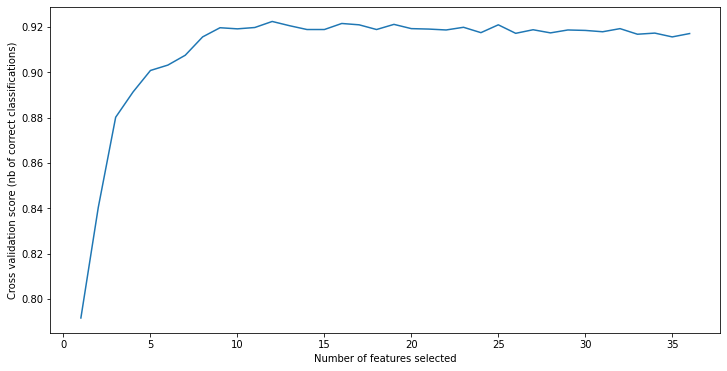

List of selected features: 
['x0' 'x3' 'x4' 'x5' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12' 'x13' 'x14']
Number of selected features: 
12


IndexError: ignored

In [ ]:
rfecv = RFECV(estimator=RandomForestClassifier())
rfecv.fit(X, y)
rfecv.transform(X)
dict_result = rfecv.cv_results_
plt.figure(figsize=(12, 6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(dict_result['mean_test_score']) + 1), dict_result['mean_test_score'])
plt.show()
rfe_features = rfecv.get_feature_names_out()
print("List of selected features: ")
print(rfe_features)
print("Number of selected features: ")
print(rfecv.n_features_)
# # Get only features selected by RFE for X and X set
X = X[rfe_features]
y = y[rfe_features]

## K-fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


from sklearn.model_selection import StratifiedKFold

cv = KFold(n_splits=10)

lst_Precision = []
lst_Recall = []
lst_f1 = []
for train_index, test_index, in cv.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
    X_test = X[test_index]
    y_test = y[test_index]  # See comment on ravel and  y_train
    
    smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=0)
    sm = SMOTETomek(random_state=42, smote=smote)
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    model = AdaBoostClassifier(random_state=0)  # Choose a model here
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred = model.predict(X_test)
    lst_Precision.append(precision_score(y_test, y_pred))
    lst_Recall.append(recall_score(y_test, y_pred))
    lst_f1.append(f1_score(y_test, y_pred))

from statistics import mean
print('Precision: ')

print(mean(lst_Precision))
print('Recall: ')

print(mean(lst_Recall))
print('F1:')

print(mean(lst_f1))
    

Precision: 
0.639335013783687
Recall: 
0.8161750038060953
F1:
0.6433947366236833


In [ ]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


from sklearn.model_selection import StratifiedKFold

cv = KFold(n_splits=10)

lst_Precision = []
lst_Recall = []
lst_f1 = []
for train_index, test_index, in cv.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
    X_test = X[test_index]
    y_test = y[test_index]  # See comment on ravel and  y_train
    
 

    model = AdaBoostClassifier(random_state=0)  # Choose a model here
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)
    lst_Precision.append(precision_score(y_test, y_pred))
    lst_Recall.append(recall_score(y_test, y_pred))
    lst_f1.append(f1_score(y_test, y_pred))

from statistics import mean
print('Precision: ')

print(mean(lst_Precision))
print('Recall: ')

print(mean(lst_Recall))
print('F1:')

print(mean(lst_f1))
    

Precision: 
0.7147333923502727
Recall: 
0.7269913592715713
F1:
0.6615939244358783


##Resample to Balance Dataset and Modeling


###**Original** dataset

In [ ]:

lst = [LogisticRegression(),
        DecisionTreeClassifier(criterion='entropy'),
        RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=0),
        SVC(),
        AdaBoostClassifier(random_state=0),
        ]

for model in lst:
    
    print(str(model))
    model.fit(X_train, y_train)
    y_test_predict = model.predict(X_test)
    print(metrics.confusion_matrix(y_test, y_test_predict))
    print(metrics.classification_report(y_test, y_test_predict))
    print('\t')

LogisticRegression()
[[2289   90]
 [ 424  197]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      2379
           1       0.69      0.32      0.43       621

    accuracy                           0.83      3000
   macro avg       0.77      0.64      0.67      3000
weighted avg       0.81      0.83      0.80      3000

	
DecisionTreeClassifier(criterion='entropy')
[[2056  323]
 [ 283  338]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2379
           1       0.51      0.54      0.53       621

    accuracy                           0.80      3000
   macro avg       0.70      0.70      0.70      3000
weighted avg       0.80      0.80      0.80      3000

	
RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=0)
[[2281   98]
 [ 321  300]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2379
        

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


###Smote 

In [ ]:
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_Smote_train, y_Smote_train = smote.fit_resample(X_train, y_train)

lst = [LogisticRegression(),
        DecisionTreeClassifier(criterion='entropy'),
        RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=0),
        SVC(),
        AdaBoostClassifier(random_state=0),
        ]

for model in lst:
    lst_metrics = []
    print(str(model))
    model.fit(X_Smote_train, y_Smote_train)
    y_test_predict = model.predict(X_test)
    print(metrics.classification_report(y_test, y_test_predict))


LogisticRegression()
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      2379
           1       0.41      0.72      0.52       621

    accuracy                           0.72      3000
   macro avg       0.66      0.72      0.66      3000
weighted avg       0.81      0.72      0.75      3000

DecisionTreeClassifier(criterion='entropy')
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      2379
           1       0.45      0.55      0.50       621

    accuracy                           0.77      3000
   macro avg       0.66      0.69      0.67      3000
weighted avg       0.79      0.77      0.78      3000

RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=0)
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2379
           1       0.61      0.63      0.62       621

    accuracy                          

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


### Smote Enn

In [ ]:
# SMOTE-ENN
sme = SMOTEENN(random_state=42, smote=smote)
X_SmoteENN_train, y_SmoteENN_train = sme.fit_resample(X_train, y_train)
lst = [LogisticRegression(),
        DecisionTreeClassifier(criterion='entropy'),
        RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=0),
        SVC(),
        AdaBoostClassifier(random_state=0),
        ]

for model in lst:
    lst_metrics = []
    print(str(model))
    model.fit(X_SmoteENN_train, y_SmoteENN_train)
    y_test_predict = model.predict(X_test)
    print(metrics.classification_report(y_test, y_test_predict))


LogisticRegression()
              precision    recall  f1-score   support

           0       0.92      0.63      0.74      2379
           1       0.36      0.79      0.49       621

    accuracy                           0.66      3000
   macro avg       0.64      0.71      0.62      3000
weighted avg       0.80      0.66      0.69      3000

DecisionTreeClassifier(criterion='entropy')
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      2379
           1       0.44      0.75      0.55       621

    accuracy                           0.75      3000
   macro avg       0.68      0.75      0.69      3000
weighted avg       0.82      0.75      0.77      3000

RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=0)
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2379
           1       0.48      0.75      0.59       621

    accuracy                          

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


### Smote - tomeklinks


In [ ]:
smt = SMOTETomek(random_state=42, smote=smote)
X_Tomek_train, y_Tomek_train = smt.fit_resample(X_train, y_train)
lst = [LogisticRegression(),
        DecisionTreeClassifier(criterion='entropy'),
        RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=0),
        SVC(),
        AdaBoostClassifier(random_state=0),
        ]

for model in lst:
    lst_metrics = []
    print(str(model))
    model.fit(X_Tomek_train, y_Tomek_train)
    y_test_predict = model.predict(X_test)
    print(metrics.confusion_matrix(y_test, y_test_predict))
    print(metrics.classification_report(y_test, y_test_predict))

LogisticRegression()
[[1727  652]
 [ 174  447]]
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      2379
           1       0.41      0.72      0.52       621

    accuracy                           0.72      3000
   macro avg       0.66      0.72      0.66      3000
weighted avg       0.80      0.72      0.75      3000

DecisionTreeClassifier(criterion='entropy')
[[2003  376]
 [ 277  344]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2379
           1       0.48      0.55      0.51       621

    accuracy                           0.78      3000
   macro avg       0.68      0.70      0.69      3000
weighted avg       0.80      0.78      0.79      3000

RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=0)
[[2127  252]
 [ 233  388]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2379
           1

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
!pip install scikit-learn==1.0 -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

from imblearn.ensemble import EasyEnsembleClassifier 
eec = EasyEnsembleClassifier(random_state=0)

eec.fit(X_train, y_train)
y_pred = eec.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[1802  577]
 [ 132  489]]
              precision    recall  f1-score   support

           0       0.93      0.76      0.84      2379
           1       0.46      0.79      0.58       621

    accuracy                           0.76      3000
   macro avg       0.70      0.77      0.71      3000
weighted avg       0.83      0.76      0.78      3000

